## Coding Exercise #0805

### 1. Time series and prediction:

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

2024-05-23 16:53:56.154737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 16:53:56.975504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


python3: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
tensorflow: 2.16.1
keras: 3.3.3
numpy: 1.26.3
pandas: 2.2.2
sklearn: 1.4.2


#### 1.1. Read in the data and explore:

In [2]:
!wget --no-clobber https://raw.githubusercontent.com/tn-220/SIC-Machine-Learning/main/SIC_ML_Coding_Exercises/SIC_ML_Chapter_09_Coding_Exercises/data_time_series.csv

File ‘data_time_series.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv('data_time_series.csv', header='infer',encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

(41, 1)


In [4]:
# Display the data frame.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


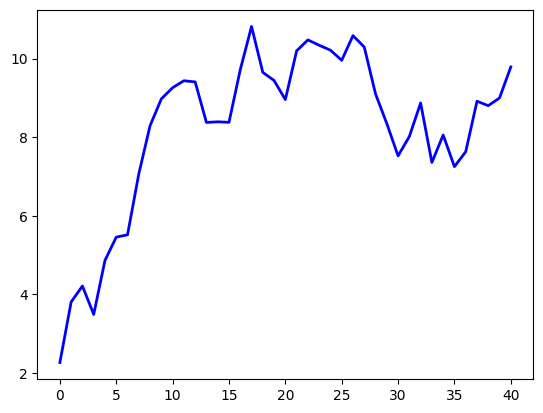

In [5]:
# Visualize the time series.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. Apply the exponential smoothing method and predict:

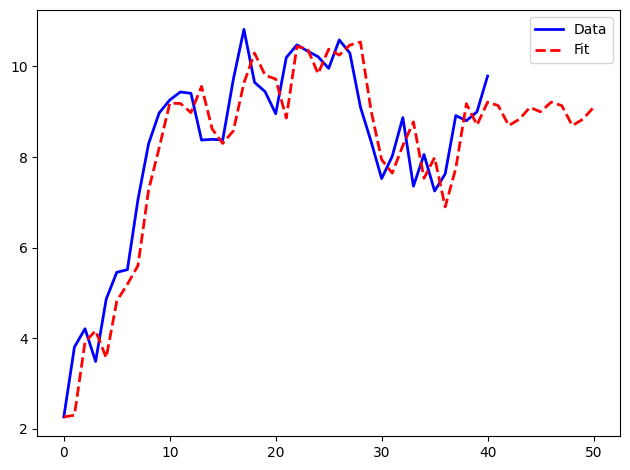

In [6]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start= 0, end=50)
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Recurrent neural network (RNN):

#### 2.1. Pre-processing:

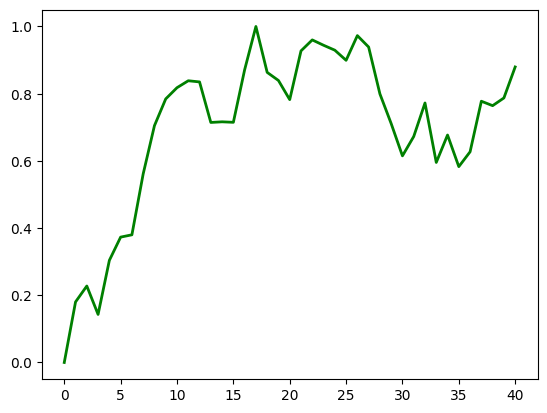

In [7]:
# Scaling.
# Please, pay attention to the vertical scale of the plot.
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [8]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

#### 2.2. Do the necessary definitions:

Hyperparameters.

In [9]:
n_epochs = 1001
batch_size = 1                    # There is only 1 time series data. No other choice but 1.
learn_rate = 0.0002

In [10]:
n_input = 1                       # Scalar input.
n_neurons = 100                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

Model.

In [11]:
# RNN or LSTM network.
# return_sequnces = True: means "Sequence to Sequence".
# input_shape = (None, n_inputs) : variable length of the time series.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))     # RNN.
#my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

2024-05-23 16:53:59.459202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 16:53:59.493917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 16:53:59.494013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 16:53:59.497431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 16:53:59.497489: I external/local_xla/xla/stream_executor

In [12]:
# View the summary.
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 100)      │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Define the optimizer and compile.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

#### 2.3. Train the model:

In [14]:
# No validation.
# CAUTION: y is X shifted by +1.
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/1001


I0000 00:00:1716476046.079819  620868 service.cc:145] XLA service 0x5573b5610b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716476046.079894  620868 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-05-23 16:54:06.195327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 16:54:06.606658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0650 - mse: 0.0650
Epoch 2/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0430 - mse: 0.0430
Epoch 3/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0400 - mse: 0.0400
Epoch 4/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0418 - mse: 0.0418
Epoch 5/1001


I0000 00:00:1716476048.156983  620868 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0399 - mse: 0.0399
Epoch 6/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0344 - mse: 0.0344
Epoch 7/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0283 - mse: 0.0283
Epoch 8/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0239 - mse: 0.0239
Epoch 9/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0221 - mse: 0.0221
Epoch 10/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0220 - mse: 0.0220
Epoch 11/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0216 - mse: 0.0216
Epoch 12/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0201 - mse: 0.0201
Epoch 13/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0178 - mse: 0.0178
Epoch 14/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0158 - mse: 0.0158
Epoch 15/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0149 - mse: 0.0149
Epoch 16/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0151 - mse: 0.0151
Epoch 17/1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

In [15]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

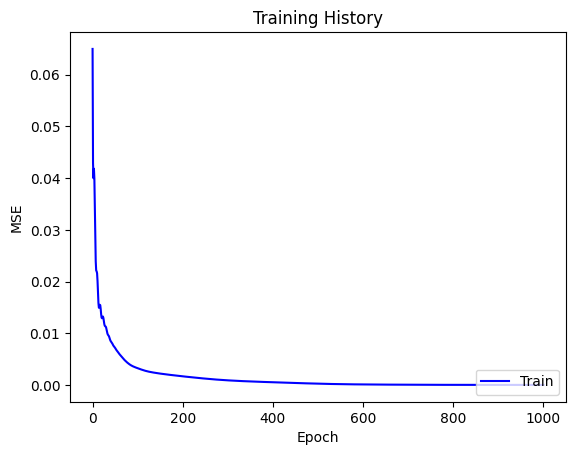

In [16]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

#### 2.4. Predict the future:

In [17]:
n_ts_seed = 5                                 # Seed length.
n_predict_time_steps = 55                     # Prediction length.

In [20]:
# Prediction loop.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.
    y_pred = my_model(X, training=False)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

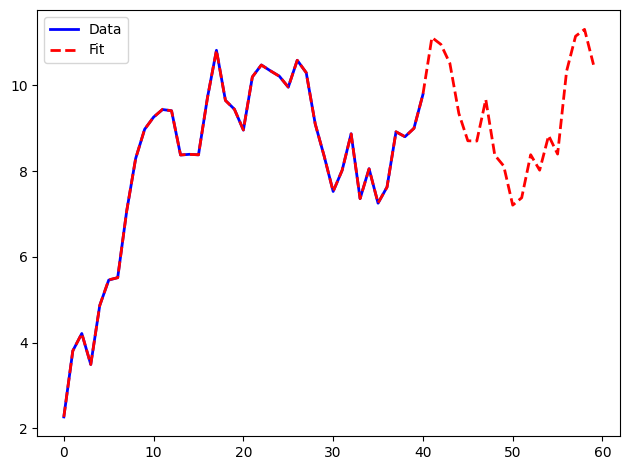

In [21]:
# Do the inverse transform and show the times series.
ts = scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.tight_layout()
plt.savefig("out.png")
plt.show()